# Possibly the last iteration

### The plan:

- Describe the dataset
- Talk first easy NN just to see the difference in the data-cleaning part
- Data cleaning, each significant step will have its own nn try
- Different architectures
- Optimizing hyperparameters

*The LSTM ans the creation of the windows (timeseries) will be done in a separate window*

## Sensor Data

The sensors are monitoring environmental factors, we can specify the following types of sensor data:
1. Temperature (TEMP)
2. Humidity (HUM)
...

The costly sensor is assumed to measure **Black Carbon concentration (BC)**, which requires more advanced technology and calibration, thus making it more expensive.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
data = pd.read_csv("BC-Data-Set.csv")
data = data.set_index(pd.to_datetime(data['date']))
data.describe()

,BC,N_CPC,PM-10,PM-2.5,PM-1.0,NO2,O3,SO2,CO,NO,NOX,TEMP,HUM
count,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000
mean,1.309454,13.651880,15.132366,9.302461,7.259924,30.032402,48.139158,1.368459,0.312924,7.796788,41.608059,17.833411,70.848520
std,1.122286,8.236568,14.254218,6.089592,5.479391,21.779951,26.104559,0.799323,0.211781,18.525452,45.400829,6.122027,15.161241
min,0.110000,1.376000,0.600000,0.500000,0.333000,2.000000,1.000000,0.500000,0.100000,0.500000,1.000000,4.083000,19.383000
25%,0.658500,7.725500,8.550000,5.050000,3.200000,14.000000,30.000000,1.000000,0.200000,1.000000,17.000000,12.750000,60.483500
50%,0.971000,11.547000,12.883000,7.933000,5.817000,23.000000,49.000000,1.000000,0.200000,3.000000,28.000000,17.133000,72.083000
75%,1.513000,17.505500,18.467000,11.900000,9.658500,40.000000,65.000000,2.000000,0.300000,6.000000,48.000000,22.775000,83.025000
max,12.767000,73.490000,398.717000,76.833000,34.383000,132.000000,142.000000,13.000000,1.900000,255.000000,521.000000,34.983000,100.000000


#now we can fill the days that are missing some hours, we will do that using the mean
test = data.groupby([data.index.date])
for group_name, group_data in test:
    if len(group_data)!=24:
        existing_hours=group_data.index.hour.unique()
        missing_hours = set(range(24)) - set(existing_hours)
        missing_rows = pd.DataFrame(columns=group_data.columns)
        for missing_hour in missing_hours:
            datetime_obj = pd.to_datetime(group_data.index.date[0]) + pd.to_timedelta(missing_hour, unit='H')
            data.loc[datetime_obj] = data.mean()

We can see that outliers are present, let's remove them.
We will scale the values too, the NN needs this to work efficiently

In [2]:
data = data.sort_index()
data = data.reset_index(drop=True)
dates = data["date"]
data = data.drop(["date"], axis=1)

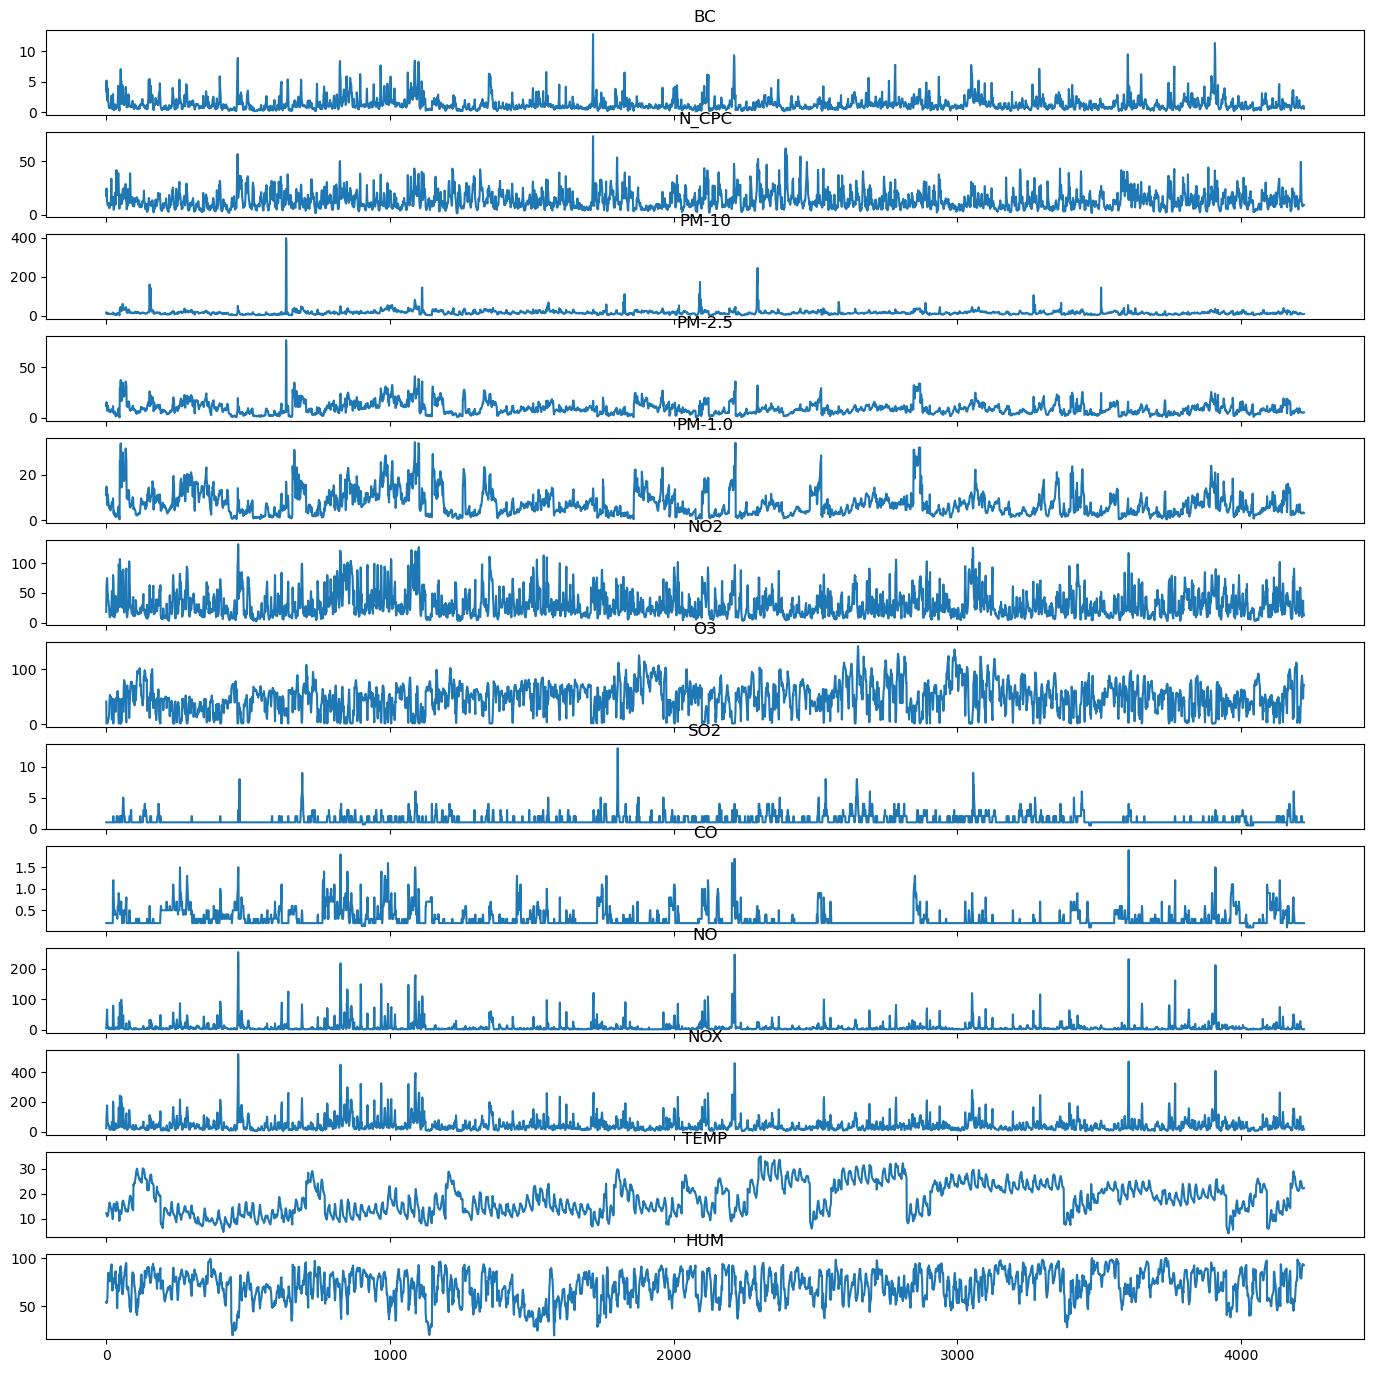

In [3]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(data, data.columns)

In [4]:
threshold = 6 # theshold a little high to retain some outliers
z_scores = np.abs((data - data.mean()) / data.std())
outliers = (z_scores > threshold).any(axis=1)
for column in data.columns:
    column_median = data[column].median()
    data.loc[outliers, column] = column_median

In [5]:
# Normalize the data, this is a rudimentary MinMaxScaler
max_df = data.max()
min_df = data.min()

data_norm = (data - min_df)/(max_df - min_df)
data_norm = pd.DataFrame(data_norm, columns=data.columns)

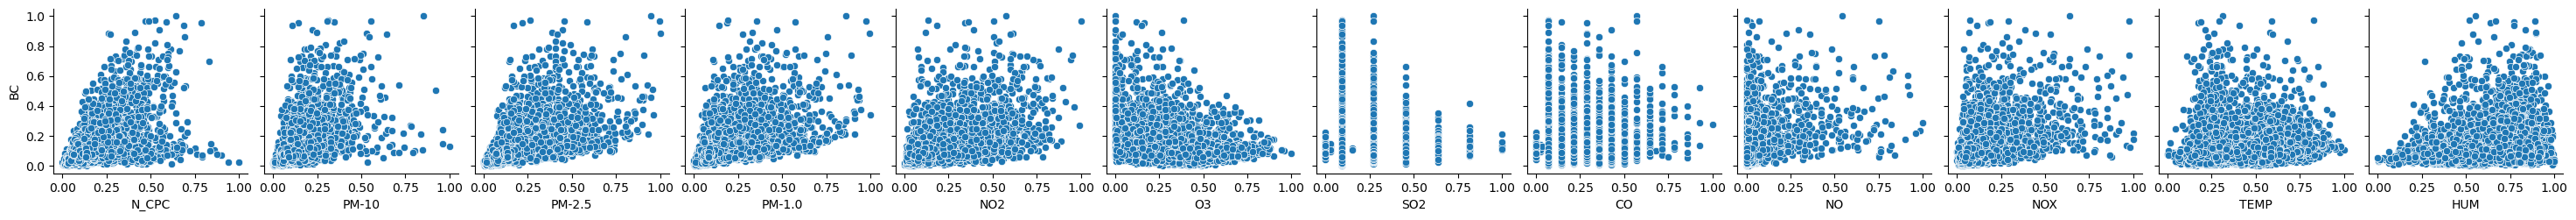

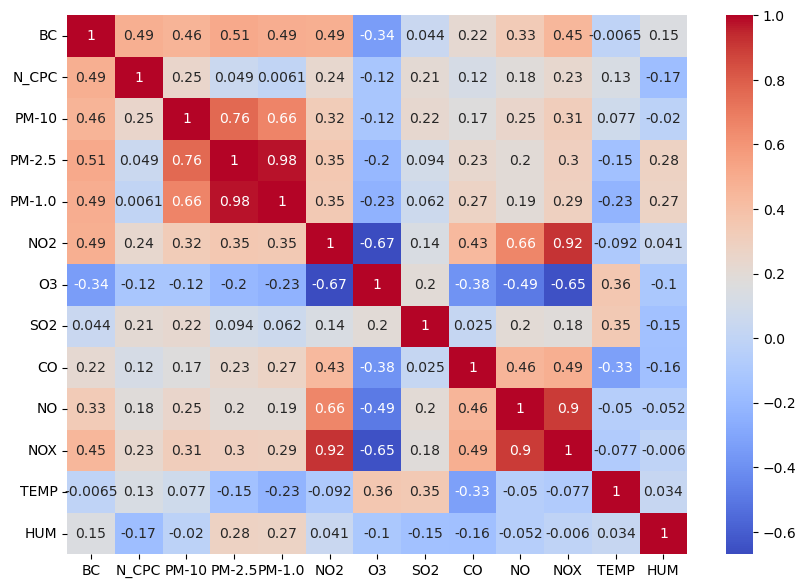

In [6]:
correlations = data_norm.corr()
# Scatter plots
sns.pairplot(data_norm, x_vars=data_norm.columns[1:], y_vars=['BC'])

# Heat map
plt.figure(figsize=(10, 7))
sns.heatmap(correlations, annot=True, cmap="coolwarm")
plt.show()

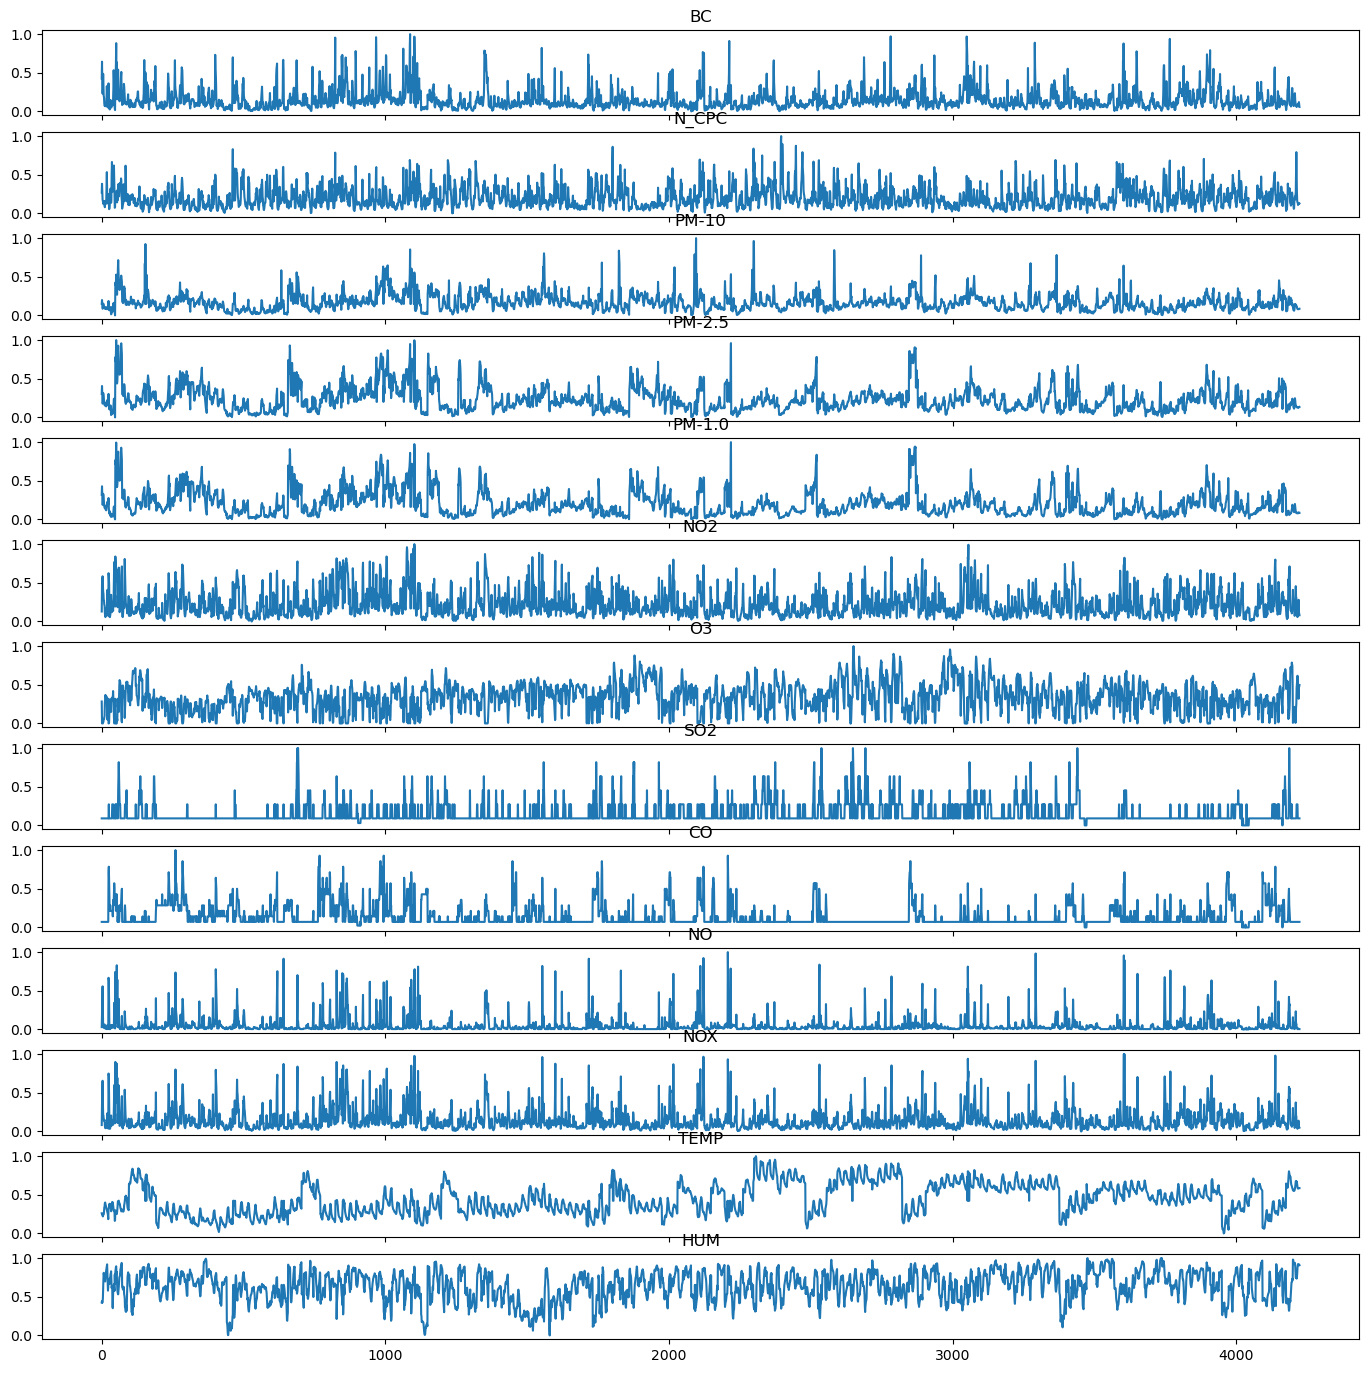

In [7]:
inspect_dataframe(data_norm, data.columns)

#### Talk first easy NN just to see the difference in the data-cleaning part

In [8]:
import tensorflow as tf
import os
import random
import seaborn as sns
import matplotlib as mpl
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import L1

warnings.filterwarnings("ignore")
tfk = tf.keras
tfkl = tf.keras.layers
tf.config.set_visible_devices([], 'GPU') #disables GPU
print(tf.__version__)

2.12.0


In [9]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [10]:
# just to prove that is the same as the classic MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

target = pd.DataFrame(data.BC)
X = data.drop(['BC'], axis=1)
print('Boston data_normset shape',X.shape)
print('Target shape', target.shape)
X.describe()

scaler_x = MinMaxScaler()
x_scaled = scaler_x.fit_transform(X)
x_scaled = pd.DataFrame(x_scaled, columns=X.columns)

#do the same for y

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target) 
y_scaled = pd.DataFrame(y_scaled, columns=target.columns)


y_scaled.describe()   
x_scaled.describe()

Boston data_normset shape (4223, 12)
Target shape (4223, 1)


,N_CPC,PM-10,PM-2.5,PM-1.0,NO2,O3,SO2,CO,NO,NOX,TEMP,HUM
count,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000
mean,0.199064,0.166848,0.233498,0.202697,0.218400,0.337157,0.151573,0.146254,0.051341,0.142144,0.444265,0.640195
std,0.131193,0.106712,0.155194,0.158948,0.166377,0.182161,0.125568,0.138598,0.107548,0.137840,0.196471,0.186467
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.104720,0.096247,0.123313,0.085579,0.096000,0.212766,0.090909,0.071429,0.004255,0.059925,0.282379,0.514780
50%,0.167747,0.148705,0.201071,0.162730,0.168000,0.340426,0.090909,0.071429,0.021277,0.101124,0.422330,0.653708
75%,0.261046,0.211864,0.303866,0.270534,0.288000,0.453901,0.212091,0.142857,0.046809,0.168539,0.601424,0.788717
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
#split in test and train

# X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size = 0.2, random_state=seed, shuffle=True)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

test_size = 24*19

X_train = x_scaled.iloc[:-test_size]
y_train = y_scaled.iloc[:-test_size]
X_test = x_scaled.iloc[-test_size:]
y_test = y_scaled.iloc[-test_size:]


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3767, 12) (3767, 1)
(456, 12) (456, 1)


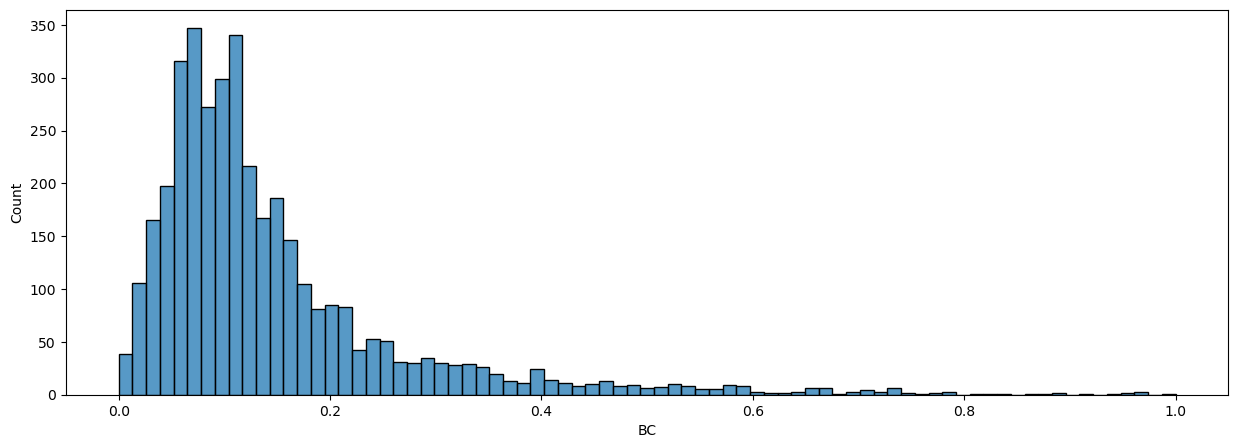

In [12]:
# Inspect the target
plt.figure(figsize=(15,5))
sns.histplot(data=y_train, x='BC')
plt.show()

In [13]:
input_shape = X_train.shape[1:]
input_shape

(12,)

In [79]:
def build_ffnn(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    layer = tfkl.Dense(units=512, activation='relu')(input_layer)
    layer = tfkl.Dense(units=512, activation='relu')(layer)
    layer = tfkl.Dropout(rate=0.5)(layer)
    layer = tfkl.Dense(units=512, activation='relu')(layer)
    output_layer = tfkl.Dense(units=1, activation='linear', name='Output')(layer)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='FFNN')

    # Compile the model
    loss = tfk.losses.MeanSquaredError()
    learning_rate = 0.2
    optimizer = tfk.optimizers.legacy.SGD(learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics=[tfk.metrics.MeanAbsoluteError(), tfk.metrics.RootMeanSquaredError()])

    # Return the model
    return model

In [80]:
ffnn = build_ffnn(input_shape)
ffnn.summary()

Model: "FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 12)]              0         
                                                                 
 dense_45 (Dense)            (None, 512)               6656      
                                                                 
 dense_46 (Dense)            (None, 512)               262656    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_47 (Dense)            (None, 512)               262656    
                                                                 
 Output (Dense)              (None, 1)                 513       
                                                                 
Total params: 532,481
Trainable params: 532,481
Non-trainable 

In [81]:
batch_size = 128
epochs = 5000

In [82]:
history = ffnn.fit(
    x = X_train,
    y = y_train, 
    batch_size = batch_size,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=100,  restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=50, factor=0.5, min_lr=1e-5)
                            ],
    epochs = epochs
).history

Epoch 1/5000
24/24 [==============================] - 0s 7ms/step - loss: 0.0165 - mean_absolute_error: 0.0859 - root_mean_squared_error: 0.1285 - val_loss: 0.0122 - val_mean_absolute_error: 0.0764 - val_root_mean_squared_error: 0.1104 - lr: 0.2000
Epoch 2/5000
24/24 [==============================] - 0s 4ms/step - loss: 0.0106 - mean_absolute_error: 0.0679 - root_mean_squared_error: 0.1028 - val_loss: 0.0110 - val_mean_absolute_error: 0.0625 - val_root_mean_squared_error: 0.1049 - lr: 0.2000
Epoch 3/5000
24/24 [==============================] - 0s 7ms/step - loss: 0.0094 - mean_absolute_error: 0.0627 - root_mean_squared_error: 0.0970 - val_loss: 0.0102 - val_mean_absolute_error: 0.0625 - val_root_mean_squared_error: 0.1008 - lr: 0.2000
Epoch 4/5000
24/24 [==============================] - 0s 5ms/step - loss: 0.0090 - mean_absolute_error: 0.0618 - root_mean_squared_error: 0.0951 - val_loss: 0.0099 - val_mean_absolute_error: 0.0599 - val_root_mean_squared_error: 0.0993 - lr: 0.2000
Epoc

In [ ]:
scores = ffnn.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


In [ ]:
y_pred=ffnn.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print("MSE",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

In [ ]:
from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(scaler_y.inverse_transform(y_test),scaler_y.inverse_transform(y_pred)))
print("R2",r2_score(scaler_y.inverse_transform(y_test),scaler_y.inverse_transform(y_pred)))

In [ ]:
def plot_residuals(model, X_, y_):
    X_['sort'] = y_
    X_ = X_.sort_values(by=['sort'])
    y_ = np.expand_dims(X_['sort'], 1)
    X_.drop(['sort'], axis=1, inplace=True)

    y_pred = model.predict(X_)
    SSE = np.square(scaler_y.inverse_transform(y_pred) - scaler_y.inverse_transform(y_))
    MSE = np.mean(SSE)

    print('Mean Squared Error (MSE):', MSE)
    # mpl.rcParams.update(mpl.rcParamsDefault)
    # sns.set(font_scale=1.1, style=None, palette='Set1')
    plt.figure(figsize=(15,5))
    plt.scatter(np.arange(len(y_)), y_, label='True')
    plt.scatter(np.arange(len(y_pred)), y_pred, label='Prediction')
    
    for i in range(len(y_)):
        if(y_[i]>=y_pred[i]):
            plt.vlines(i,y_pred[i],y_[i],alpha=.5)
        else:
            plt.vlines(i,y_[i],y_pred[i],alpha=.5)
            
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

In [ ]:
plot_residuals(ffnn, X_test, y_test)

In [ ]:
plot_residuals(ffnn, X_train, y_train)